En el autoencoder debemos pasar solo las imagenes donde los pacientes sean sanos, de manera que entrenemos el autoencoder con solo patches sanos para que si la reconstrucción de un patche que es maligno tiene un error muy grande despues clasificaremos como maligno, utilizaremos solo una parte del dataset no maligno para probar el train primero

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cpu')

# PART AUTOENCODER

In [4]:
csv_dir= "/fhome/mapsiv/QuironHelico/CroppedPatches/metadata.csv"


In [5]:
def extrac_neg(csv_dir):
    metadata= pd.read_csv(csv_dir)
    negatives = metadata[metadata['DENSITAT'] == 'NEGATIVA']
    image_names = negatives['CODI'].tolist()
    image_names = [name + "_1" for name in image_names]

    return image_names

In [6]:
image_names=extrac_neg(csv_dir)
len(image_names)

151

In [7]:
train=image_names[0:16]

In [8]:
test= image_names[16:18]

In [9]:
test[0:20]

['B22-26_1', 'B22-27_1']

In [10]:
data_dir= "/fhome/mapsiv/QuironHelico/CroppedPatches/"

In [11]:
def extract_patch_paths(data_dir,lpaths):
    selected_images = []

    for image_name in lpaths:
        folder_path = os.path.join(data_dir, image_name)
        if os.path.exists(folder_path):
            # Obtén todos los patches dentro de la carpeta
            images_in_folder = [os.path.join(folder_path, image) for image in os.listdir(folder_path) if image.endswith(".png")]
            selected_images.extend(images_in_folder)
    return selected_images

In [12]:
train_patches= extract_patch_paths(data_dir, train)
len(train_patches)

4911

In [12]:
test_patches= extract_patch_paths(data_dir, test)
len(test_patches)

5301

In [5]:
class CustomDataset(Dataset):
    def __init__(self, patch_paths, transform=None):
        self.patch_paths = patch_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.patch_paths)

    def __getitem__(self, idx):
        patch_path = self.patch_paths[idx]
        image = Image.open(patch_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [14]:
transform = transforms.Compose([transforms.Resize((253, 253)), transforms.ToTensor()])

In [15]:
train_dataset = CustomDataset(train_patches, transform)
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
test_dataset = CustomDataset(test_patches, transform)
batch_size = 128
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
for batch in train_dataloader:
    for image in batch:
      img=image
    print(batch.shape)
    break


torch.Size([128, 3, 253, 253])


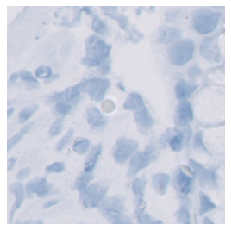

In [18]:
img=img.permute(1,2,0)

plt.imshow(img)
plt.axis('off')  # Desactiva los ejes
plt.show()

## MODEL PART

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )


        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        
        y2 = self.decoder3(x3)
        y1 = self.decoder2(y2)
        y = self.decoder1(y1)

        return y



In [20]:
autoencoder = Autoencoder()

In [21]:
autoencoder= autoencoder.to(device)

In [ ]:
criterion = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10

model_path= "/fhome/gia06/codigo/models/model1_prueba.pt"

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        inputs = batch
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()


    torch.save(autoencoder.state_dict(), model_path)
    test_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Test'):
            inputs = batch
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)
            test_loss += criterion(outputs, inputs).item()


    print(f'Época {epoch + 1}, Pérdida de Entrenamiento: {running_loss / len(train_dataloader)}, Pérdida de Prueba: {test_loss / len(test_dataloader)}')


# Muestra algunas imágenes y sus reconstrucciones después de cada época
    with torch.no_grad():
        original_images = []
        reconstructed_images = []

        for i, batch in enumerate(test_dataloader):
            if i >= 3:  # Muestra solo 3 imágenes
                break

            inputs = batch
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)

            inputs = inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()

            index = np.random.randint(0, len(inputs))

            original_images.append(inputs[index])
            reconstructed_images.append(outputs[index])

        for i in range(3):
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(np.transpose(original_images[i], (1, 2, 0)))
            plt.title('Original')

            plt.subplot(1, 2, 2)
            plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
            plt.title('Reconstrucción')

            plt.show()

Epoch 2:   0%|          | 0/39 [00:00<?, ?it/s]

Época 1, Pérdida de Entrenamiento: 0.015003248117864132, Pérdida de Prueba: 0.006020904274746066


Epoch 3:   0%|          | 0/39 [00:00<?, ?it/s]

Época 2, Pérdida de Entrenamiento: 0.00115719244021397, Pérdida de Prueba: 0.0022756704683637337


Epoch 4:   0%|          | 0/39 [00:00<?, ?it/s]

Época 3, Pérdida de Entrenamiento: 0.0005318337949948051, Pérdida de Prueba: 0.001968669242203413


Epoch 5:   0%|          | 0/39 [00:00<?, ?it/s]

Época 4, Pérdida de Entrenamiento: 0.00040969909586681006, Pérdida de Prueba: 0.0018253842357634788


Epoch 6:   0%|          | 0/39 [00:00<?, ?it/s]

Época 5, Pérdida de Entrenamiento: 0.0003484863749084373, Pérdida de Prueba: 0.0017154875205874088


Epoch 7:   0%|          | 0/39 [00:00<?, ?it/s]

Época 6, Pérdida de Entrenamiento: 0.0003046071856843833, Pérdida de Prueba: 0.0015341183142958297


Epoch 8:   0%|          | 0/39 [00:00<?, ?it/s]

Época 7, Pérdida de Entrenamiento: 0.00026699613021591154, Pérdida de Prueba: 0.0014880755694494361


Epoch 9:   0%|          | 0/39 [00:00<?, ?it/s]

Época 8, Pérdida de Entrenamiento: 0.00023628557354617768, Pérdida de Prueba: 0.0015068880637131986


Epoch 10:   0%|          | 0/39 [00:00<?, ?it/s]

Época 9, Pérdida de Entrenamiento: 0.00020523162301964103, Pérdida de Prueba: 0.0013928155170842295


Epoch 11:   0%|          | 0/39 [00:00<?, ?it/s]

Época 10, Pérdida de Entrenamiento: 0.0001852926816821146, Pérdida de Prueba: 0.001377284011271383


Epoch 12:   0%|          | 0/39 [00:00<?, ?it/s]

Época 11, Pérdida de Entrenamiento: 0.00016513970107413255, Pérdida de Prueba: 0.001299857367051854


Epoch 13:   0%|          | 0/39 [00:00<?, ?it/s]

Época 12, Pérdida de Entrenamiento: 0.00015016998730014818, Pérdida de Prueba: 0.0014788290385955147


Epoch 14:   0%|          | 0/39 [00:00<?, ?it/s]

Época 13, Pérdida de Entrenamiento: 0.0001383445539828151, Pérdida de Prueba: 0.0012622137077241426


Epoch 15:   0%|          | 0/39 [00:00<?, ?it/s]

Época 14, Pérdida de Entrenamiento: 0.0001270616615865714, Pérdida de Prueba: 0.0013519725679153843


Epoch 16:   0%|          | 0/39 [00:00<?, ?it/s]

Época 15, Pérdida de Entrenamiento: 0.00011913821258647845, Pérdida de Prueba: 0.0013628003597703007


Epoch 17:   0%|          | 0/39 [00:00<?, ?it/s]

Época 16, Pérdida de Entrenamiento: 0.00011231074817120456, Pérdida de Prueba: 0.0013025668990199587


Epoch 18:   0%|          | 0/39 [00:00<?, ?it/s]

Época 17, Pérdida de Entrenamiento: 0.00010590344437589057, Pérdida de Prueba: 0.001207305308309428


Epoch 19:   0%|          | 0/39 [00:00<?, ?it/s]

Época 18, Pérdida de Entrenamiento: 0.00010041368640929413, Pérdida de Prueba: 0.0012029510287989286


Epoch 20:   0%|          | 0/39 [00:00<?, ?it/s]

Época 19, Pérdida de Entrenamiento: 9.157600139494603e-05, Pérdida de Prueba: 0.0013534032124360757


Epoch 21:   0%|          | 0/39 [00:00<?, ?it/s]

Época 20, Pérdida de Entrenamiento: 8.828217930082853e-05, Pérdida de Prueba: 0.0012447095110214182


Epoch 22:   0%|          | 0/39 [00:00<?, ?it/s]

Época 21, Pérdida de Entrenamiento: 8.174695260375022e-05, Pérdida de Prueba: 0.0012731555477893423


Epoch 23:   0%|          | 0/39 [00:00<?, ?it/s]

Época 22, Pérdida de Entrenamiento: 7.753598858984426e-05, Pérdida de Prueba: 0.0012450205880062033


Epoch 24:   0%|          | 0/39 [00:00<?, ?it/s]

Época 23, Pérdida de Entrenamiento: 7.435063852403217e-05, Pérdida de Prueba: 0.00111207469377578


Epoch 25:   0%|          | 0/39 [00:00<?, ?it/s]

Época 24, Pérdida de Entrenamiento: 7.149828282611755e-05, Pérdida de Prueba: 0.0012167238469590388


Epoch 26:   0%|          | 0/39 [00:00<?, ?it/s]

Época 25, Pérdida de Entrenamiento: 6.607515248246133e-05, Pérdida de Prueba: 0.0012129471648395771


Epoch 27:   0%|          | 0/39 [00:00<?, ?it/s]

Época 26, Pérdida de Entrenamiento: 6.460380814715814e-05, Pérdida de Prueba: 0.0011894260255974672


Epoch 28:   0%|          | 0/39 [00:00<?, ?it/s]

Época 27, Pérdida de Entrenamiento: 6.150755031670157e-05, Pérdida de Prueba: 0.0011144134651182131


Epoch 29:   0%|          | 0/39 [00:00<?, ?it/s]

Época 28, Pérdida de Entrenamiento: 6.14488426669059e-05, Pérdida de Prueba: 0.0011266583030755143


Epoch 30:   0%|          | 0/39 [00:00<?, ?it/s]

Época 29, Pérdida de Entrenamiento: 5.851562225591177e-05, Pérdida de Prueba: 0.0011436110265397776


Epoch 31:   0%|          | 0/39 [00:00<?, ?it/s]

Época 30, Pérdida de Entrenamiento: 5.435636688698417e-05, Pérdida de Prueba: 0.0011801444010676018


Epoch 32:   0%|          | 0/39 [00:00<?, ?it/s]

Época 31, Pérdida de Entrenamiento: 5.181341261143247e-05, Pérdida de Prueba: 0.0012655464067522968


Epoch 33:   0%|          | 0/39 [00:00<?, ?it/s]

Época 32, Pérdida de Entrenamiento: 5.2141212412000946e-05, Pérdida de Prueba: 0.0010876822662318037


Epoch 34:   0%|          | 0/39 [00:00<?, ?it/s]

Época 33, Pérdida de Entrenamiento: 4.908622595860671e-05, Pérdida de Prueba: 0.0012915529909410647


Epoch 35:   0%|          | 0/39 [00:00<?, ?it/s]

Época 34, Pérdida de Entrenamiento: 4.815928397688251e-05, Pérdida de Prueba: 0.0010879099066923594


Epoch 36:   0%|          | 0/39 [00:00<?, ?it/s]

Época 35, Pérdida de Entrenamiento: 4.6510805427365434e-05, Pérdida de Prueba: 0.001156609632917458


Epoch 37:   0%|          | 0/39 [00:00<?, ?it/s]

Época 36, Pérdida de Entrenamiento: 4.636169941454099e-05, Pérdida de Prueba: 0.0011733350208184372


Epoch 38:   0%|          | 0/39 [00:00<?, ?it/s]

Época 37, Pérdida de Entrenamiento: 4.393800284164265e-05, Pérdida de Prueba: 0.0011661053895728574


Epoch 39:   0%|          | 0/39 [00:00<?, ?it/s]

Época 38, Pérdida de Entrenamiento: 4.301830370259734e-05, Pérdida de Prueba: 0.001176343989625041


Epoch 40:   0%|          | 0/39 [00:00<?, ?it/s]

Época 39, Pérdida de Entrenamiento: 3.99671033590447e-05, Pérdida de Prueba: 0.0011195435391051607


Epoch 41:   0%|          | 0/39 [00:00<?, ?it/s]

Época 40, Pérdida de Entrenamiento: 3.844438609890998e-05, Pérdida de Prueba: 0.0012150924511453404


Epoch 42:   0%|          | 0/39 [00:00<?, ?it/s]

Época 41, Pérdida de Entrenamiento: 4.016251375268882e-05, Pérdida de Prueba: 0.0012074863216617988


Epoch 43:   0%|          | 0/39 [00:00<?, ?it/s]

Época 42, Pérdida de Entrenamiento: 3.9159709185463354e-05, Pérdida de Prueba: 0.0011608353109165495


Epoch 44:   0%|          | 0/39 [00:00<?, ?it/s]

Época 43, Pérdida de Entrenamiento: 3.715578718700458e-05, Pérdida de Prueba: 0.0010326261828941781


Epoch 45:   0%|          | 0/39 [00:00<?, ?it/s]

Época 44, Pérdida de Entrenamiento: 3.7280795274851604e-05, Pérdida de Prueba: 0.0010692642286552914


Epoch 46:   0%|          | 0/39 [00:00<?, ?it/s]

Época 45, Pérdida de Entrenamiento: 3.5844344240150604e-05, Pérdida de Prueba: 0.0009549074332296316


Epoch 47:   0%|          | 0/39 [00:00<?, ?it/s]

Época 46, Pérdida de Entrenamiento: 3.4583682953290496e-05, Pérdida de Prueba: 0.0011291616468779033


Epoch 48:   0%|          | 0/39 [00:00<?, ?it/s]

Época 47, Pérdida de Entrenamiento: 3.485710723721124e-05, Pérdida de Prueba: 0.0011938974078345513


Epoch 49:   0%|          | 0/39 [00:00<?, ?it/s]

Época 48, Pérdida de Entrenamiento: 3.541101539620938e-05, Pérdida de Prueba: 0.0010731101598745834


Epoch 50:   0%|          | 0/39 [00:00<?, ?it/s]

Época 49, Pérdida de Entrenamiento: 3.247768328060957e-05, Pérdida de Prueba: 0.0011658853951043316


Test: 100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


Época 50, Pérdida de Entrenamiento: 2.982314529221278e-05, Pérdida de Prueba: 0.001078273854329295


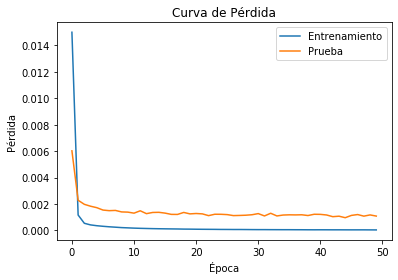

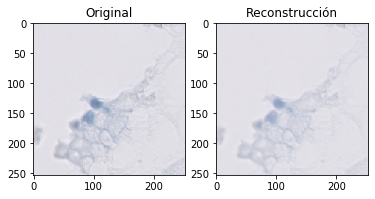

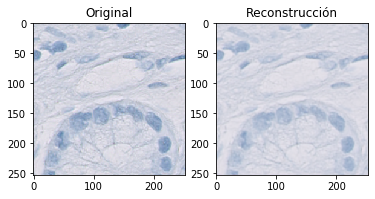

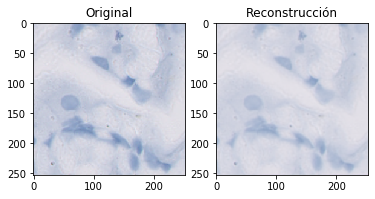

In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

criterion = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 50

model_path = "/fhome/gia06/codigo/models/model1_prueba.pt"


train_loss_history = []
test_loss_history = []


for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        inputs = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_loss_history.append(train_loss)

    test_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Test'):
            inputs = batch
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)
            test_loss += criterion(outputs, inputs).item()


    test_loss = test_loss / len(test_dataloader)
    test_loss_history.append(test_loss)


    torch.save(autoencoder.state_dict(), model_path)


    print(f'Época {epoch + 1}, Pérdida de Entrenamiento: {train_loss}, Pérdida de Prueba: {test_loss}')

# Plotea la curva de pérdida en el conjunto de train y test
plt.figure()
plt.plot(train_loss_history, label='Entrenamiento')
plt.plot(test_loss_history, label='Prueba')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida')
plt.show()

# Muestra algunas imágenes y sus reconstrucciones después de cada epoch
with torch.no_grad():
    original_images = []
    reconstructed_images = []

    for i, batch in enumerate(test_dataloader):
        if i >= 3:  
            break

        inputs = batch
        inputs = inputs.to(device)
        outputs = autoencoder(inputs)

        inputs = inputs.cpu().numpy()
        outputs = outputs.cpu().numpy()

        index = np.random.randint(0, len(inputs))

        original_images.append(inputs[index])
        reconstructed_images.append(outputs[index])

    for i in range(3):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(original_images[i], (1, 2, 0)))
        plt.title('Original')

        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        plt.title('Reconstrucción')

        plt.show()


In [ ]:
outputs

In [ ]:
#tensor_np = outputs.squeeze().cpu().detach().numpy()

# Visualiza
plt.imshow(outputs[0].transpose(1, 2, 0))
plt.show()

In [ ]:
tensor_np = inputs.squeeze().cpu().detach().numpy()

plt.imshow(tensor_np.transpose(1, 2, 0))
plt.show()

# PART CLASSIFIER

In [7]:
patches_csv_dir= "/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv"
annotated_dir= "/fhome/mapsiv/QuironHelico/AnnotatedPatches/"


In [8]:
def extrac_pos(csv_dir):
    metadata= pd.read_csv(csv_dir)
    negatives = metadata[metadata['Presence'] == 1 ]
    image_names = negatives['ID'].tolist()

    return image_names

In [9]:
def extrac_negg(csv_dir):
    metadata= pd.read_csv(csv_dir)
    negatives = metadata[metadata['Presence'] == -1 ]
    image_names = negatives['ID'].tolist()

    return image_names

In [10]:
pos_pacients= extrac_pos(patches_csv_dir)
len(pos_pacients)

164

In [11]:
neg_pacients= extrac_negg(patches_csv_dir)
len(neg_pacients)

1091

In [12]:
def create_paths(dir,patches):
     images=[path.replace('.', '/') for path in patches]
     paths=[]
     for img in images:
        
          path=os.path.join(dir, img)
          paths.append(path)

     patchs_paths = [path + ".png" for path in paths if os.path.exists(path + '.png')]
     return patchs_paths
     

In [13]:
pos_patch_paths= create_paths(annotated_dir,pos_pacients)
pos_patch_paths[0:2]

['/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-101_0/00201.png',
 '/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-102_0/01468.png']

In [14]:
neg_path_paths= create_paths(annotated_dir,neg_pacients)
neg_path_paths[0:2]


['/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-101_0/00180.png',
 '/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-101_0/00280.png']

VALE, AHORA ESTAMOS DEFINIENDO LAS TRANSFORMACIONES PARA LAS IMAGENES POSITIVAS PARA HACER DATA AUGMENTATION, NO HACE FALTA TEST SET YA QUE QUEREMOS LA LOSS DE TODOS Y DESPUES CUANDO TENGAMOS LA LOSS YA HAREMOS EL SPLIT.

In [15]:
transform = transforms.Compose([transforms.Resize((253, 253)), transforms.ToTensor()])

In [16]:
positive_dataset = CustomDataset(pos_patch_paths, transform)
batch_size = 32
positive_dataloader = DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)

In [17]:
neg_dataset = CustomDataset(neg_path_paths, transform)
batch_size = 32
negative_dataloader = DataLoader(neg_dataset, batch_size=batch_size, shuffle=True)

## SVM AND LoR

In [18]:
len(negative_dataloader)

35

In [19]:
len(positive_dataloader)

6

In [20]:

for batch in positive_dataloader:
        print(batch.shape)
        for image in batch:
            img=image
        break

torch.Size([32, 3, 253, 253])


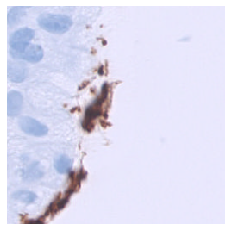

In [21]:
img=img.permute(1,2,0)

plt.imshow(img)
plt.axis('off')  # Desactiva los ejes
plt.show()

In [22]:

for batch in negative_dataloader:
        print(batch.shape)
        for image in batch:
            img=image
        break

torch.Size([32, 3, 253, 253])


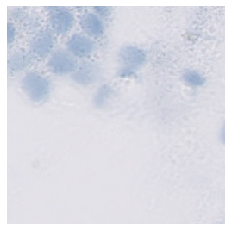

In [23]:
img=img.permute(1,2,0)

plt.imshow(img)
plt.axis('off')  # Desactiva los ejes
plt.show()

In [26]:
device

device(type='cpu')

In [24]:
model = Autoencoder()
model.load_state_dict(torch.load("/fhome/gia06/codigo/models/model50?.pt"))
model.eval()
criterion = nn.MSELoss()
positive_losses = []

with torch.no_grad():
    for batch in tqdm(positive_dataloader, desc='Processing Images'):
        for image in batch:
            inputs = image.unsqueeze(0)
            outputs = model(inputs)

            loss = criterion(outputs, inputs).item()
            positive_losses.append(loss)


print(positive_losses)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [35]:
img1=inputs[0]
img2=outputs[0]

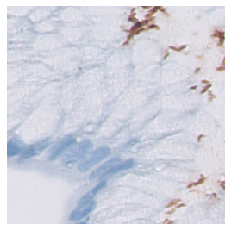

In [36]:
img1=img1.permute(1,2,0)

plt.imshow(img1)
plt.axis('off')  # Desactiva los ejes
plt.show()

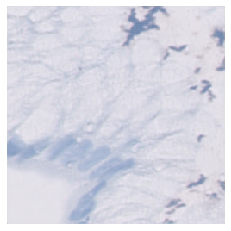

In [37]:
img2=img2.permute(1,2,0)

plt.imshow(img2)
plt.axis('off')  # Desactiva los ejes
plt.show()

In [43]:
inputs.shape

torch.Size([1, 3, 253, 253])

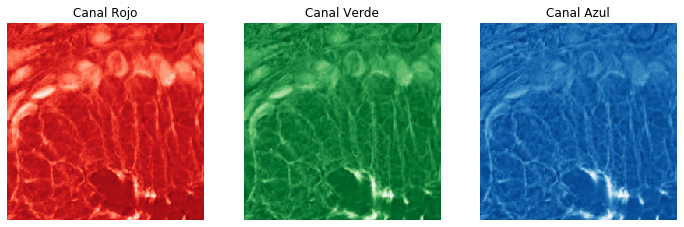

In [45]:
rojo = inputs[0][0]
verde = inputs[0][1]
azul = inputs[0][2]

# Creamos una figura con tres subplots para cada canal
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Graficamos los canales
axs[0].imshow(rojo, cmap='Reds')
axs[0].set_title('Canal Rojo')
axs[0].axis('off')

axs[1].imshow(verde, cmap='Greens')
axs[1].set_title('Canal Verde')
axs[1].axis('off')

axs[2].imshow(azul, cmap='Blues')
axs[2].set_title('Canal Azul')
axs[2].axis('off')

plt.show()

In [46]:
rojo=rojo.view(-1).sum()
azul=azul.view(-1).sum()
verde=verde.view(-1).sum()

print(rojo,azul,verde)

tensor(50667.1758) tensor(54086.3477) tensor(51154.7031)


In [47]:
redness = max(0, rojo - (azul + verde) / 2)
redness

0

In [24]:
negative_losses = []

with torch.no_grad():
    for batch in tqdm(negative_dataloader, desc='Processing Images'):
        for image in batch:
            inputs = image.unsqueeze(0)
            outputs = model(inputs)

            loss = criterion(outputs, inputs).item()
            negative_losses.append(loss)


print(negative_losses)



Processing Images: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]

[0.0012706913985311985, 0.0009566129883751273, 0.0018356123473495245, 0.0008914661593735218, 0.0009257212514057755, 0.0009992645354941487, 0.0012333233607932925, 0.0009620361379347742, 0.0016586270648986101, 0.0006041330634616315, 0.010832034982740879, 0.0013788742944598198, 0.0011527593014761806, 0.001660417765378952, 0.001221431652083993, 0.0009888154454529285, 0.0012021398870274425, 0.0010844382923096418, 0.0005705854273401201, 0.0010962516535073519, 0.0010985458502545953, 0.0011026521679013968, 0.0013824484776705503, 0.0015812681522220373, 0.0012834565714001656, 0.0005452846526168287, 0.0009359734831377864, 0.0011638306314125657, 0.000855243590194732, 0.0007222145213745534, 0.0008847468998283148, 0.0010790199739858508, 0.0008807855774648488, 0.00116415333468467, 0.00030996600980870426, 0.0009726499556563795, 0.0016943621449172497, 0.0009672163869254291, 0.0007738794083707035, 0.0010441209888085723, 0.00033882653224281967, 0.001325614983215928, 0.0007558729848824441, 0.0006238911300

Try with losses:

In [25]:
len(positive_losses)

163

In [26]:
len(negative_losses)


1091

In [27]:
crop_negative_losses=negative_losses[0:200]
len(crop_negative_losses)

200

In [28]:

labels_negatives = np.zeros(len(crop_negative_losses))

In [29]:
labels_positive = np.ones(len(positive_losses))



In [30]:
labels= np.concatenate((labels_positive, labels_negatives))


In [31]:
values= np.concatenate((positive_losses, crop_negative_losses))
values = values.reshape(-1, 1)

In [32]:
normalized_values=[]
minimo=min(values)
maximo=max(values)
for i in values:
    normalized_value=(i-minimo) / (maximo - minimo)
    normalized_values.append(normalized_value)


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(normalized_values, labels, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Exactitud: {accuracy}")
print("Reporte de clasificación:")
print(report)


Exactitud: 0.547945205479452
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69        37
         1.0       1.00      0.08      0.15        36

    accuracy                           0.55        73
   macro avg       0.76      0.54      0.42        73
weighted avg       0.76      0.55      0.43        73



/fhome/gia06/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(normalized_values, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("Resultados del SVM:")
print(f"Exactitud: {accuracy_svm}")
print("Reporte de clasificación:")
print(report_svm)

Resultados del SVM:
Exactitud: 0.5068493150684932
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.67        37
         1.0       0.00      0.00      0.00        36

    accuracy                           0.51        73
   macro avg       0.25      0.50      0.34        73
weighted avg       0.26      0.51      0.34        73



/fhome/gia06/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CONTINUING WITH REDNESS

In [ ]:
model = Autoencoder()
model.load_state_dict(torch.load("/fhome/gia06/codigo/models/model50?.pt"))
model.eval()
criterion = nn.MSELoss()
diferencias_redness_pos = []

with torch.no_grad():
    for batch in tqdm(positive_dataloader, desc='Processing Images'):
        for image in batch:
            inputs = image.unsqueeze(0)
            outputs = model(inputs)

            rojo1 = inputs[0][0]
            verde1 = inputs[0][1]
            azul1 = inputs[0][2]

            rojo2 = outputs[0][0]
            verde2 = outputs[0][1]
            azul2 = outputs[0][2]

            rojo1=rojo1.view(-1).sum()
            azul1=azul1.view(-1).sum()
            verde1=verde1.view(-1).sum()
            redness1 = max(0, rojo - (azul + verde) / 2)

            rojo2=rojo2.view(-1).sum()
            azul2=azul2.view(-1).sum()
            verde2=verde2.view(-1).sum()
            redness2 = max(0, rojo - (azul + verde) / 2)

            diff_rednes= redness1-redness2
            diferencias_redness_pos.append(diff_rednes)

            loss = criterion(outputs, inputs).item()


In [ ]:
diferencias_redness_neg = []

with torch.no_grad():
    for batch in tqdm(negative_dataloader, desc='Processing Images'):
        for image in batch:
            inputs = image.unsqueeze(0)
            outputs = model(inputs)

            rojo1 = inputs[0][0]
            verde1 = inputs[0][1]
            azul1 = inputs[0][2]

            rojo2 = outputs[0][0]
            verde2 = outputs[0][1]
            azul2 = outputs[0][2]

            rojo1=rojo1.view(-1).sum()
            azul1=azul1.view(-1).sum()
            verde1=verde1.view(-1).sum()
            redness1 = max(0, rojo - (azul + verde) / 2)

            rojo2=rojo2.view(-1).sum()
            azul2=azul2.view(-1).sum()
            verde2=verde2.view(-1).sum()
            redness2 = max(0, rojo - (azul + verde) / 2)

            diff_rednes= redness1-redness2
            diferencias_redness_neg.append(diff_rednes)

            loss = criterion(outputs, inputs).item()




In [ ]:
# fit into the classifier

crop_negative_redness=diferencias_redness_neg[0:200]
labels_negatives = np.zeros(len(crop_negative_redness))
labels_positive = np.ones(len(diferencias_redness_pos))


labels= np.concatenate((labels_positive, labels_negatives))

values= np.concatenate((diferencias_redness_pos, crop_negative_redness))
values = values.reshape(-1, 1)


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(normalized_values, labels, test_size=0.2, random_state=42)

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Exactitud: {accuracy}")
print("Reporte de clasificación:")
print(report)